In [52]:
import PIL
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature as feature
from PIL import Image 
from io import BytesIO
import cv2
import extcolors
from colormap import rgb2hex

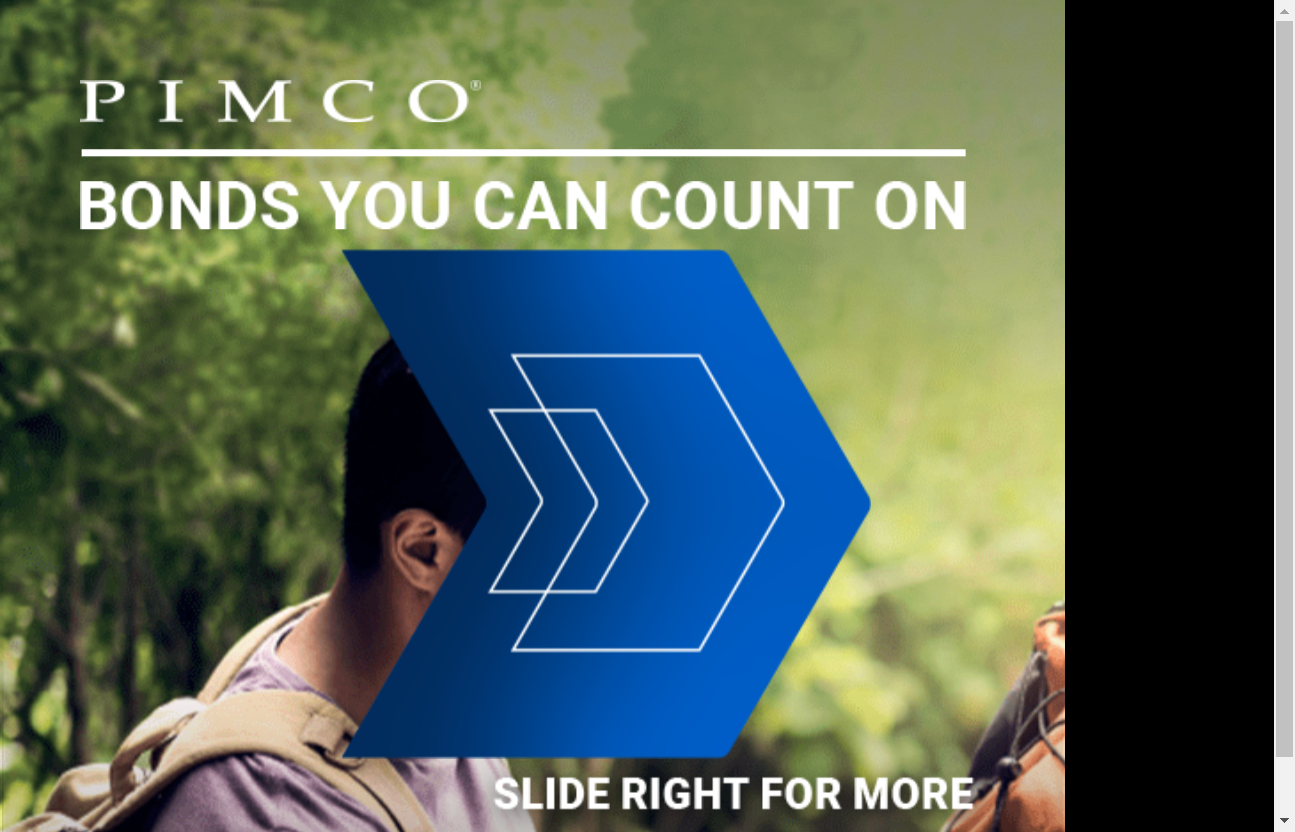

In [53]:
im1 = "../data/Creative Assets_/0ec0761596c0bc902de8789a0597029b-6995198c87f21dc3f836.png"
Image.open(im1)

### Color extraction

In [28]:
colors_x = extcolors.extract_from_path(im1, tolerance = 12, limit = 12)

In [65]:
# Shows red, green, blue and occurace number in the image
colors_x[:10]

([((0, 0, 0), 202107),
  ((133, 142, 99), 132310),
  ((62, 78, 38), 108826),
  ((0, 89, 190), 94369),
  ((149, 164, 103), 93401),
  ((198, 206, 118), 68871),
  ((1, 44, 93), 60338),
  ((90, 112, 52), 44267),
  ((255, 255, 255), 36220),
  ((0, 67, 141), 30709),
  ((35, 54, 28), 28136),
  ((30, 36, 33), 26191)],
 1077440)

In [59]:
colors_x[0][10][0]

(35, 54, 28)

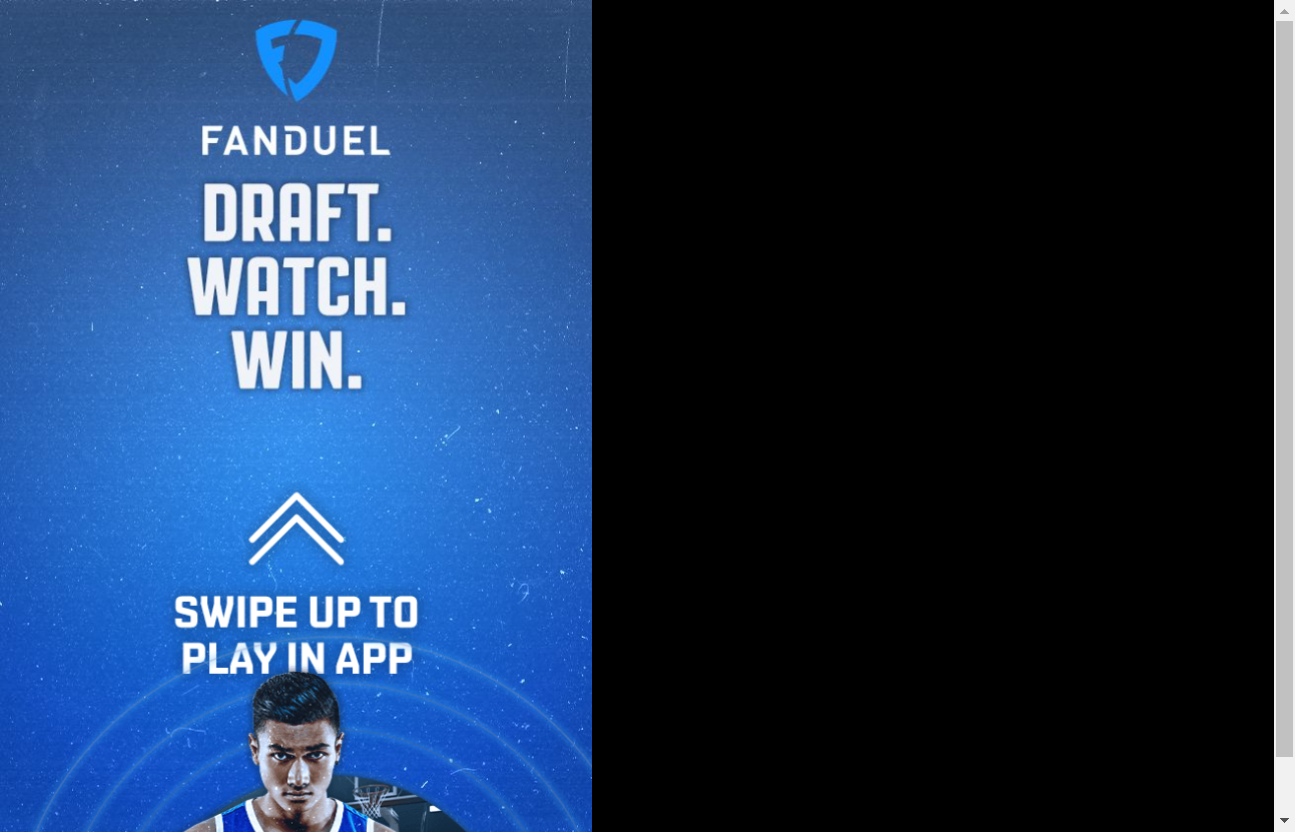

In [60]:
im2 = '../data/Creative Assets_/93df2121520164ce1ef4b78150c00c25-07d22c748652271a8024.png'
Image.open(im2)

In [63]:
def image_info(im_path):
    # get the spatial dimensions of the image

    # initialize the origin
    image = plt.imread(im_path)

    # get the image height and width
    height, width = image.shape[:2]

    # compute the center of the image
    # which is simply the width and height
    # divided by two
    (centerX, centerY) = (width // 2, height // 2)

    print('Image height: ', height)
    print('Image width: ', width)
    print('Center location: ', (centerY, centerX))

In [64]:
image_info(im1)

Image height:  832
Image width:  1295
Center location:  (416, 647)
